In [66]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# Load the dataset
df = pd.read_csv(
    "./data/miner_revenue_data.csv",
    usecols=["Date", "Price", "Fees(BTC)", "MinerRevenuePercentage", "Issuance(BTC)"]
)

# Parse the Date column and set it as the index
df["Date"] = pd.to_datetime(df["Date"], format="%Y-%m-%dT%H:%M:%S%z")

# Convert the "Date" column in df to timezone-naive
df["Date"] = pd.to_datetime(df["Date"], errors="coerce").dt.tz_localize(None)

df.set_index("Date", inplace=True)

# Calculate Fees(USD) and Issuance(USD)
df["Fees(USD)"] = df["Fees(BTC)"] * df["Price"]
df["Issuance(USD)"] = df["Issuance(BTC)"] * df["Price"]

# Compute btc log returns and vols
df['Daily_Log_Return'] = np.log(df['Price'] / df['Price'].shift(1))
df['Annual_RV'] = df['Daily_Log_Return'].rolling(365).std() * np.sqrt(365)
df['Monthly_RV'] = df['Daily_Log_Return'].rolling(30).std() * np.sqrt(365)

# Load the total hash rate dataset
hash_rate_df = pd.read_csv(
    "./data/total_hash_rate.csv",
    usecols=["Date", "hash-rate"]
)

# Rename hash-rate to HashRate
hash_rate_df.rename(columns={"hash-rate": "HashRate"}, inplace=True)

# Check and convert the "Date" column to datetime
hash_rate_df["Date"] = pd.to_datetime(hash_rate_df["Date"], errors="coerce")

# Ensure the column does not have timezone information
hash_rate_df["Date"] = hash_rate_df["Date"].dt.tz_localize(None)

# Merge the two DataFrames while retaining `NaN` for missing dates in `hash_rate_df`
df = df.merge(hash_rate_df, on="Date", how="left")

# Set the index to the Date column
df.set_index("Date", inplace=True)

blockchain_halving_dates = [pd.to_datetime("28-Nov-2012"), pd.to_datetime("9-Jul-2016"), pd.to_datetime("11-May-2020"), pd.to_datetime("19-Apr-2024"), ]

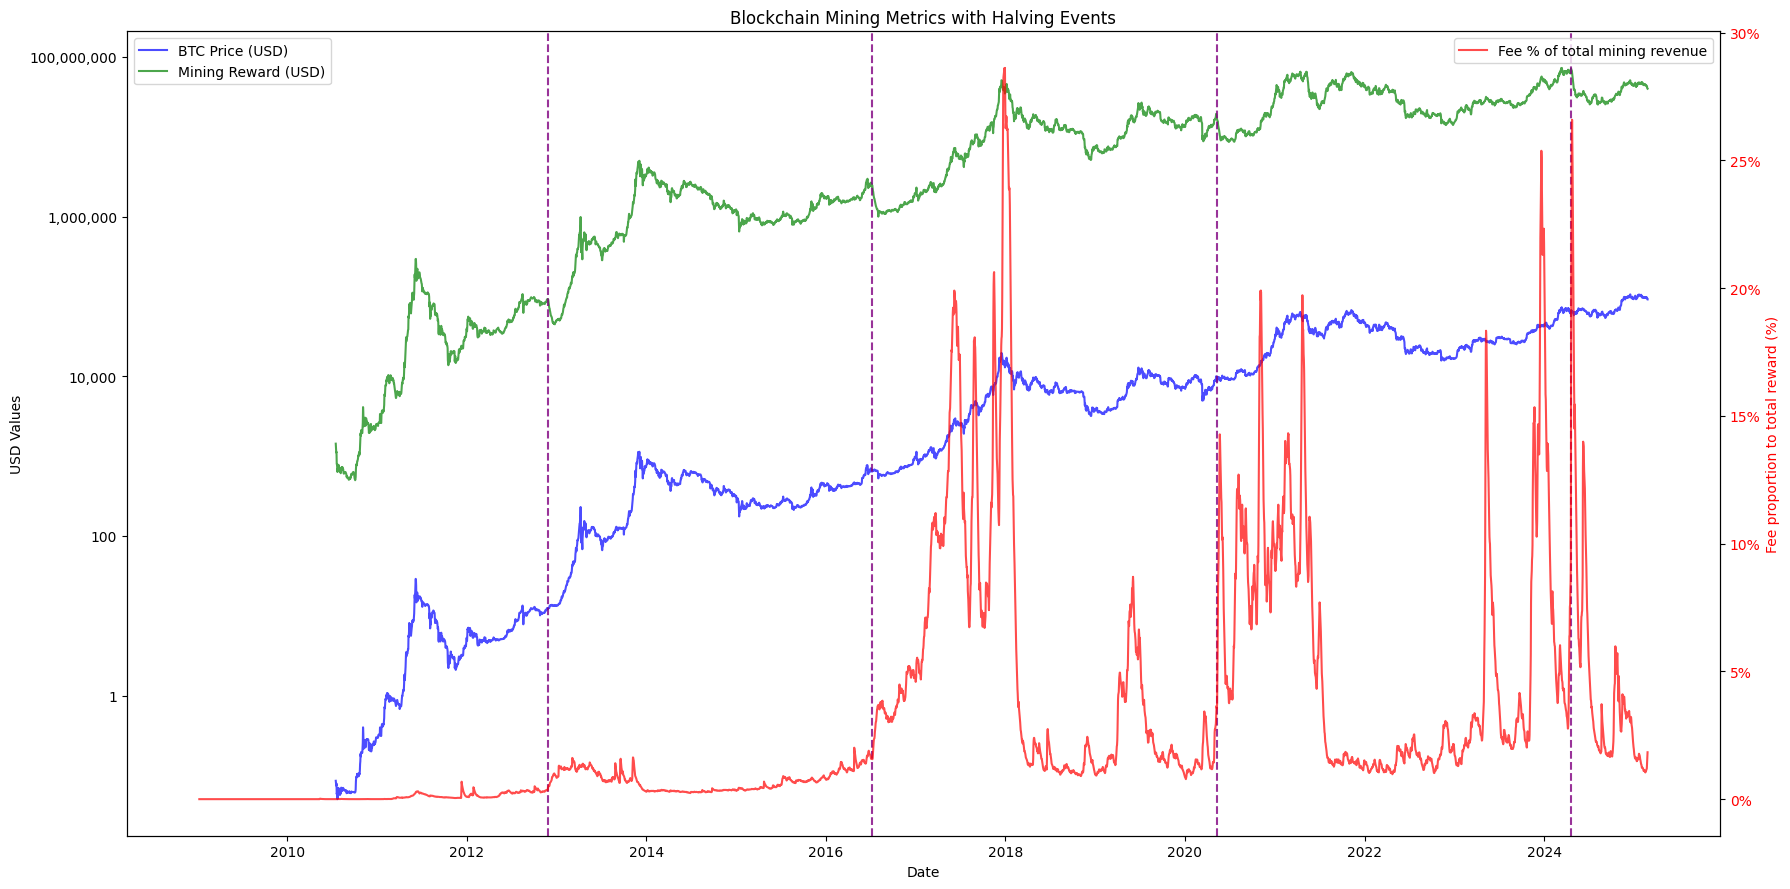

In [69]:
save_figures = True

fig, ax1 = plt.subplots(figsize=(18, 9))

# Ensure df.index is datetime before plotting
if not isinstance(df.index, pd.DatetimeIndex):
    raise ValueError("DataFrame index is not a valid DatetimeIndex. Please ensure the index is datetime formatted.")

# Plot Price, Fees(USD), and Issuance(USD) on the first axis
ax1.plot(df.index, df["Price"], label="BTC Price (USD)", color="blue", alpha=0.7)
ax1.plot(df.index, df["Fees(USD)"] + df["Issuance(USD)"], label="Mining Reward (USD)", color="green", alpha=0.7)
ax1.set_xlabel("Date")
ax1.set_ylabel("USD Values", color="black")
ax1.set_yscale("log")  # Set y-axis to logarithmic scale

# Use 1000 comma separator instead of scientific notation
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:,.0f}"))

ax1.tick_params(axis="y")
ax1.legend(loc="upper left")

# Plot Fees / Issuance on the second axis
ax2 = ax1.twinx()
ax2.plot(df.index, df["MinerRevenuePercentage"], label="Fee % of total mining revenue", color="red", alpha=0.7)
ax2.set_ylabel("Fee proportion to total reward (%)", color="red")
ax2.tick_params(axis="y", labelcolor="red")
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{y:.0%}"))  # Format as percentage
ax2.legend(loc="upper right")

# Add vertical lines for blockchain halving dates
for date in blockchain_halving_dates:
    ax1.axvline(date, color="purple", linestyle="--", alpha=0.8)

plt.title("Blockchain Mining Metrics with Halving Events")
plt.tight_layout()

if save_figures:
    # Save the chart to a file in ./results
    plt.savefig('./results/blockchain_metrics_with_halving_events.png', dpi=300)
else:
    plt.show()

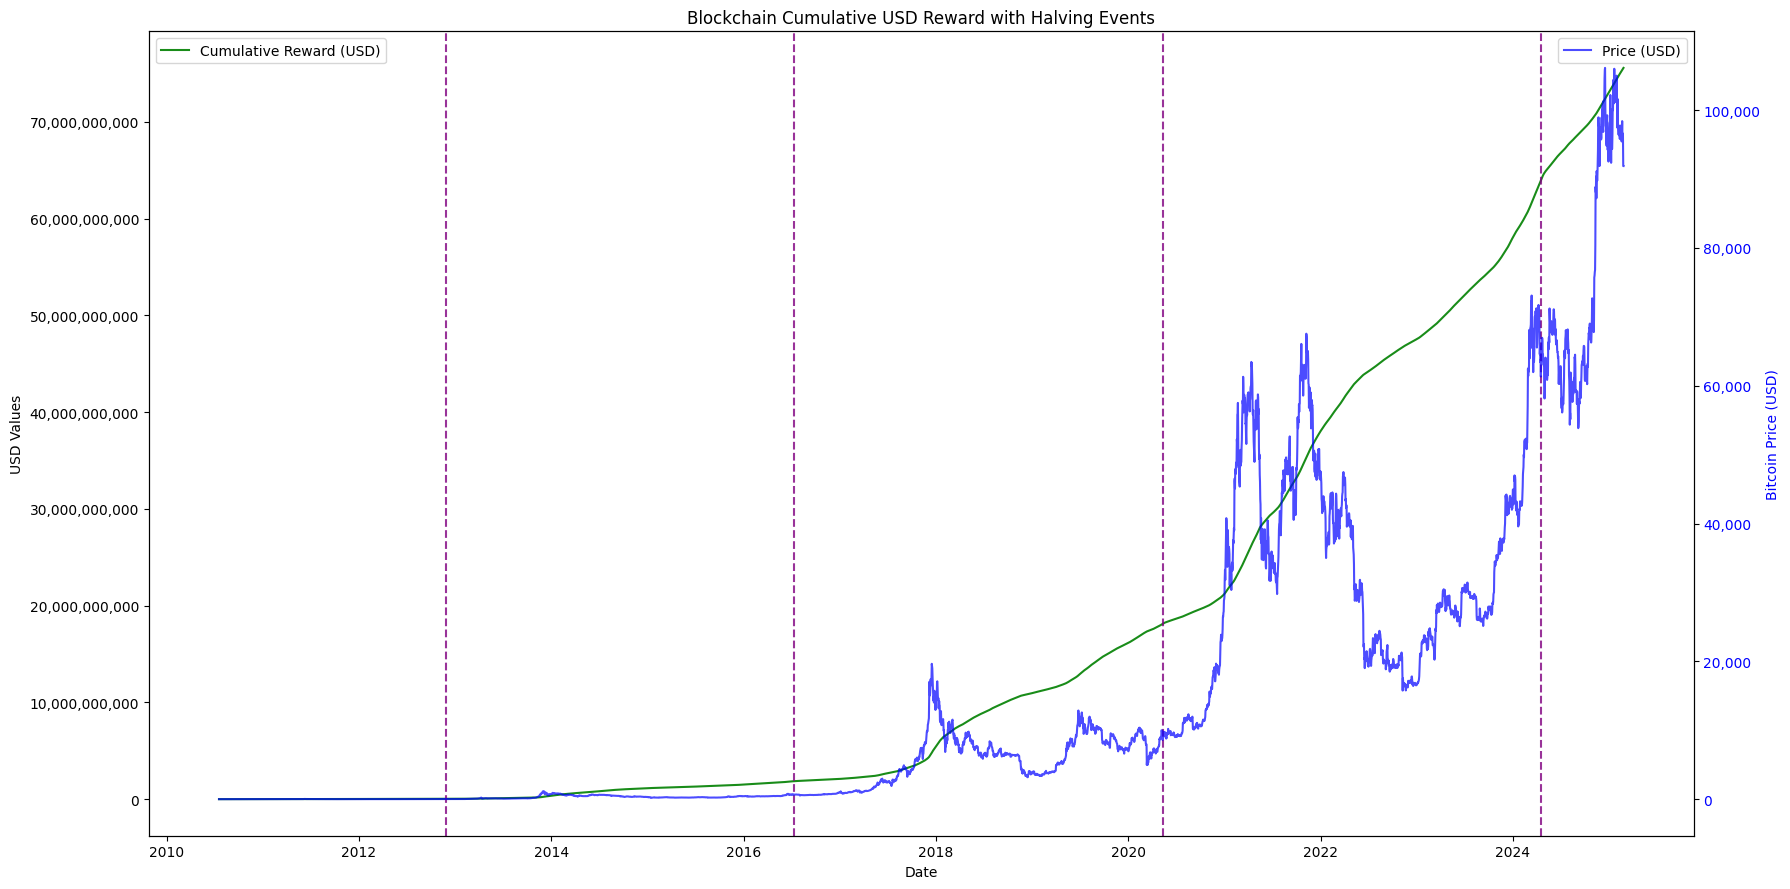

In [62]:
# Calculate the cumulative total mining reward (Fees + Issuance)
df["CumulativeReward(USD)"] = (df["Fees(USD)"] + df["Issuance(USD)"]).cumsum()
df["CumulativeRewardHodl(USD)"] = (df["Fees(BTC)"] + df["Issuance(BTC)"]).cumsum() * df["Price"]

# Plotting
fig, ax1 = plt.subplots(figsize=(18, 9))

# Plot Price, Fees(USD), and Issuance(USD) on the first axis
ax1.plot(df.index, df["CumulativeReward(USD)"], label="Cumulative Reward (USD)", color="green", linestyle="-", alpha=0.9)
ax1.set_xlabel("Date")
ax1.set_ylabel("USD Values", color="black")
#ax1.set_yscale("log")  # Set y-axis to logarithmic scale

# Use 1000 comma separator instead of scientific notation
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:,.0f}"))

ax1.tick_params(axis="y")
ax1.legend(loc="upper left")

# Plot Fees / Issuance on the second axis
ax2 = ax1.twinx()
ax2.plot(df.index, df["Price"], label="Price (USD)", color="blue", alpha=0.7)
ax2.set_ylabel("Bitcoin Price (USD)", color="blue")
ax2.tick_params(axis="y", labelcolor="blue")
ax2.legend(loc="upper right")

# Use 1000 comma separator instead of scientific notation
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:,.0f}"))

# Add vertical lines for blockchain halving dates
for date in blockchain_halving_dates:
    ax1.axvline(date, color="purple", linestyle="--", alpha=0.8)

plt.title("Blockchain Cumulative USD Reward with Halving Events")
plt.tight_layout()

if save_figures:
    # Save the chart to a file in ./results
    plt.savefig('./results/blockchain_cumulative_reward_metrics_with_halving_events.png', dpi=300)
else:
    plt.show()

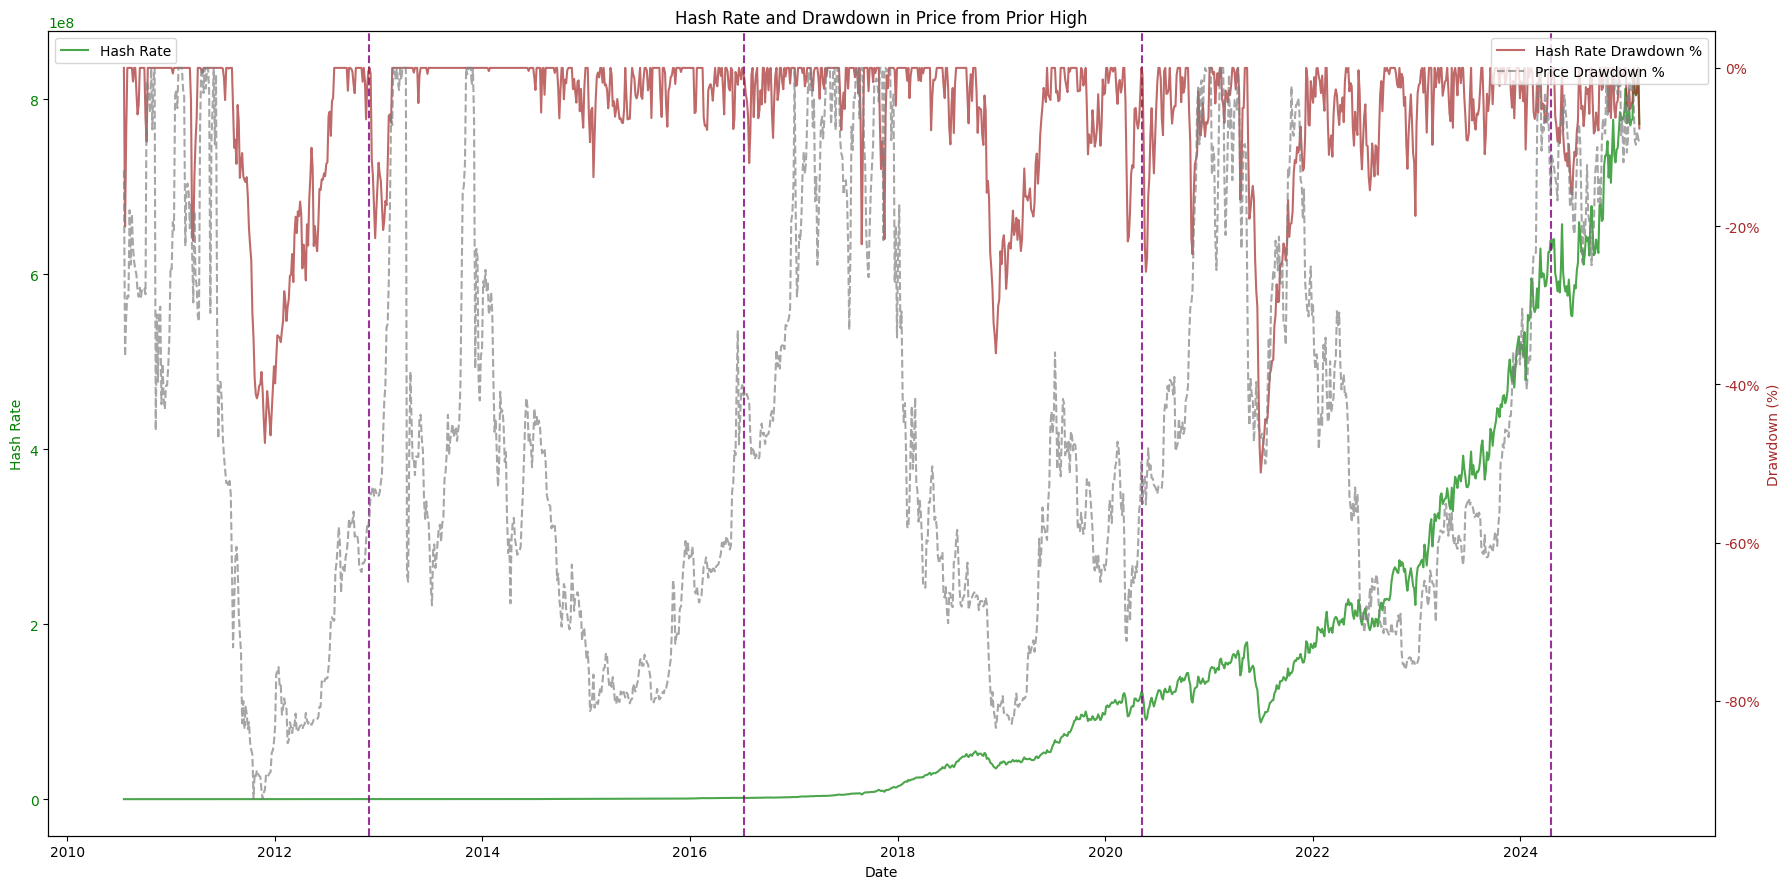

In [52]:
# Calculate the drawdown from prior high based on HashRate
df["HashRateHigh"] = df["HashRate"].cummax()
df["HashRateDrawdown"] = (df["HashRate"] - df["HashRateHigh"]) / df["HashRateHigh"]

# Calculate the drawdown from prior high based on Price
df["PriceHigh"] = df["Price"].cummax()
df["PriceDrawdown"] = (df["Price"] - df["PriceHigh"]) / df["PriceHigh"]

# Exclude NaN values
df_filtered = df.dropna(subset=["HashRate", "HashRateDrawdown", "PriceDrawdown"])

# Plotting
fig, ax1 = plt.subplots(figsize=(18, 9))

# Plot HashRate on the first axis
ax1.plot(df_filtered.index, df_filtered["HashRate"], label="Hash Rate", color="green", alpha=0.7)
ax1.set_xlabel("Date")
ax1.set_ylabel("Hash Rate", color="green")
ax1.tick_params(axis="y", labelcolor="green")
ax1.legend(loc="upper left")

# Plot Drawdown (in Price) on the second axis
ax2 = ax1.twinx()
ax2.plot(df_filtered.index, df_filtered["HashRateDrawdown"], label="Hash Rate Drawdown %", color="brown", alpha=0.7)
ax2.plot(df_filtered.index, df_filtered["PriceDrawdown"], label="Price Drawdown %", linestyle='--', color="grey", alpha=0.7)
ax2.set_ylabel("Drawdown (%)", color="brown")
ax2.tick_params(axis="y", labelcolor="brown")
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{y:.0%}"))  # Format as percentage
ax2.legend(loc="upper right")

# Add vertical lines for blockchain halving dates
for date in blockchain_halving_dates:
    ax1.axvline(date, color="purple", linestyle="--", alpha=0.8)

plt.title("Hash Rate and Drawdown in Price from Prior High")
plt.tight_layout()

if save_figures:
    # Save the chart to a file in ./results
    plt.savefig('./results/blockchain_hash_rate_metrics.png', dpi=300)
else:
    plt.show()

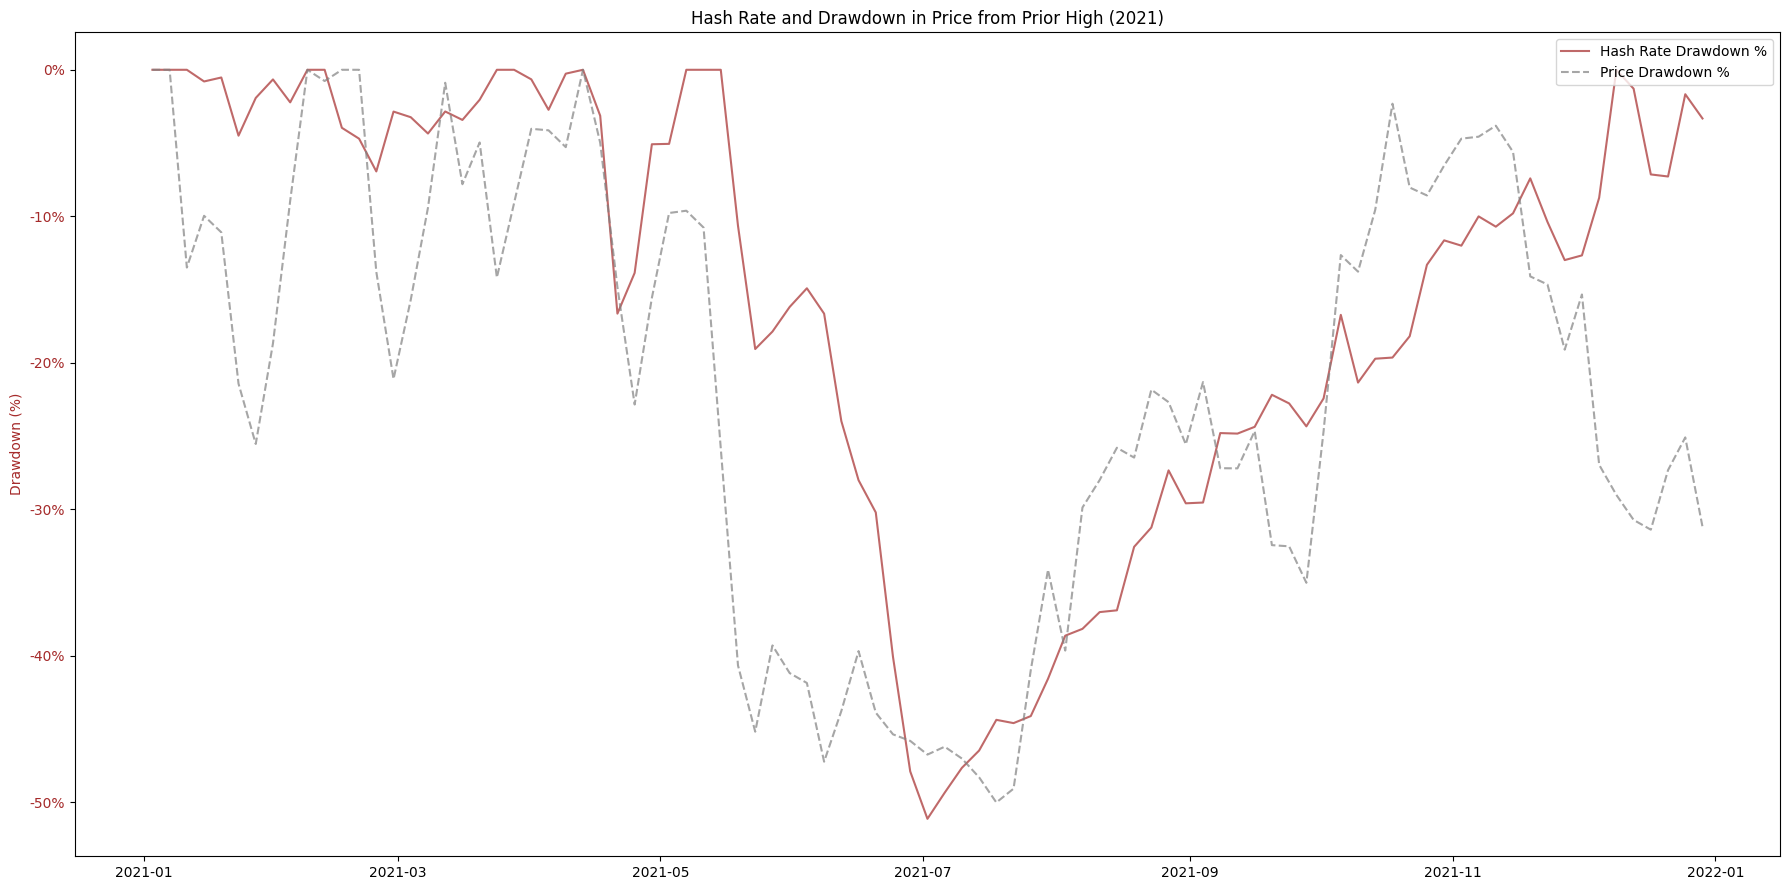

In [53]:
# Filter the DataFrame to include only data from 2021
df_filtered = df.loc[df.index.year == 2021].dropna(subset=["HashRate", "HashRateDrawdown", "PriceDrawdown"])

# Plotting
fig, ax1 = plt.subplots(figsize=(18, 9))

# Plot Drawdown (in Price) on the second axis
ax1.plot(df_filtered.index, df_filtered["HashRateDrawdown"], label="Hash Rate Drawdown %", color="brown", alpha=0.7)
ax1.plot(df_filtered.index, df_filtered["PriceDrawdown"], label="Price Drawdown %", linestyle='--', color="grey", alpha=0.7)
ax1.set_ylabel("Drawdown (%)", color="brown")
ax1.tick_params(axis="y", labelcolor="brown")
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{y:.0%}"))  # Format as percentage
ax1.legend(loc="upper right")

plt.title("Hash Rate and Drawdown in Price from Prior High (2021)")
plt.tight_layout()

if save_figures:
    # Save the chart to a file in ./results
    plt.savefig('./results/blockchain_hash_rate_metrics_2021.png', dpi=300)
else:
    plt.show()

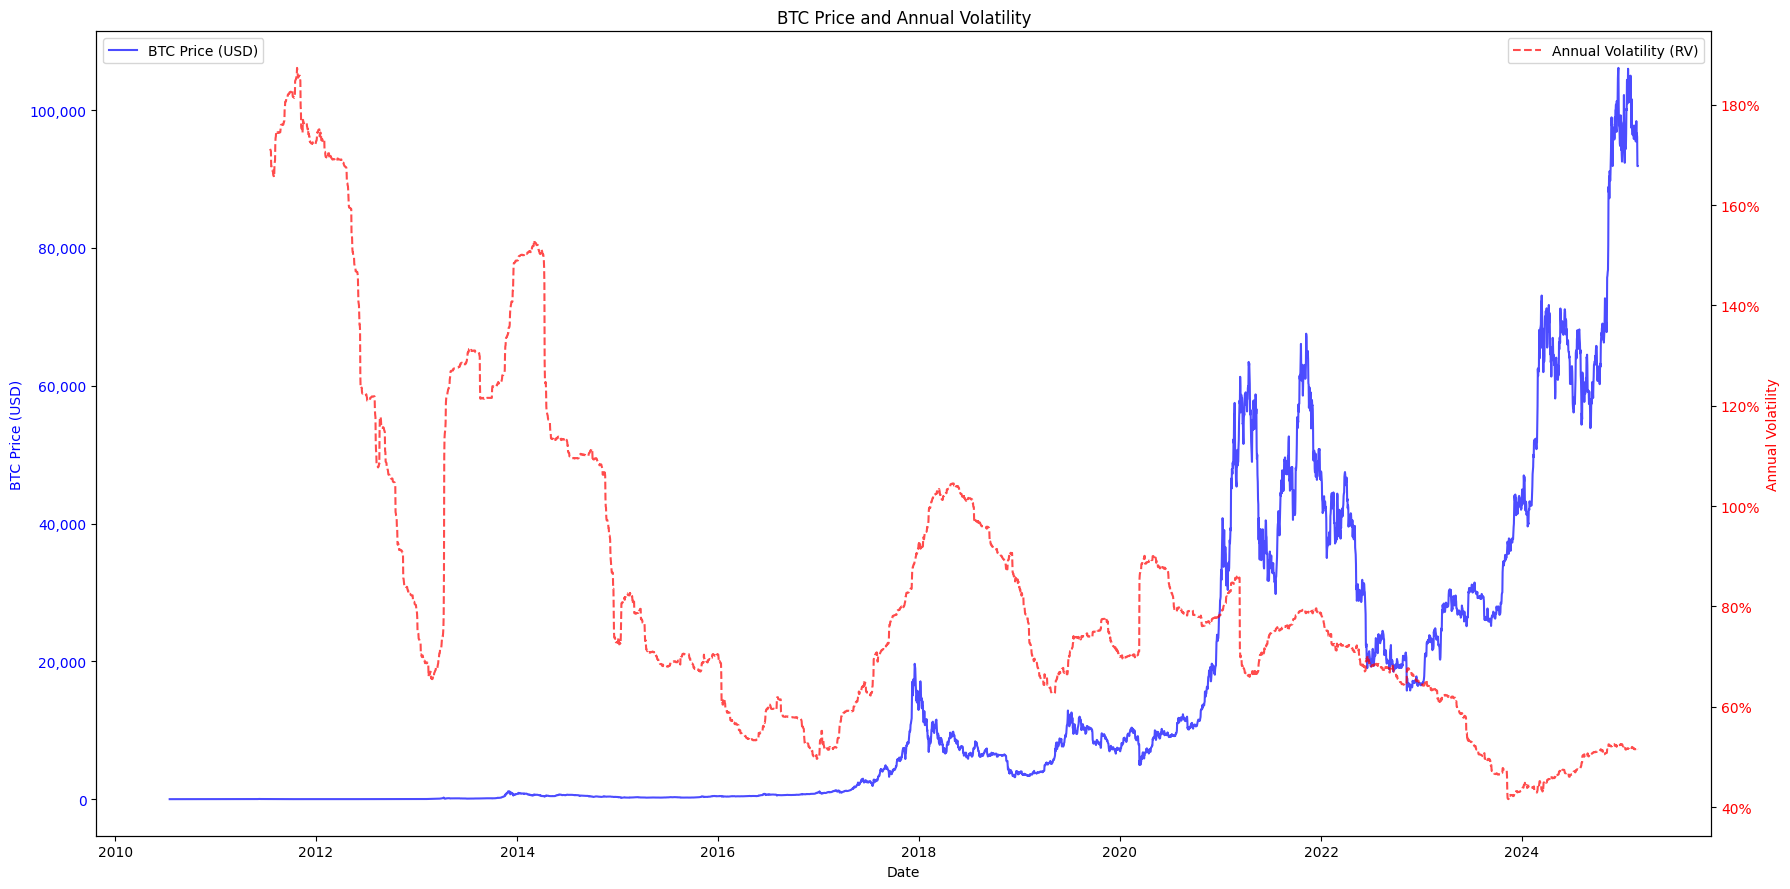

In [70]:
fig, ax1 = plt.subplots(figsize=(18, 9))

# Ensure df.index is datetime before plotting
if not isinstance(df.index, pd.DatetimeIndex):
    raise ValueError("DataFrame index is not a valid DatetimeIndex. Please ensure the index is datetime formatted.")

# Plot Price on the first axis
ax1.plot(df.index, df["Price"], label="BTC Price (USD)", color="blue", alpha=0.7)
ax1.set_xlabel("Date")
ax1.set_ylabel("BTC Price (USD)", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

# Use 1,000 comma separator for the first axis
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:,.0f}"))
ax1.legend(loc="upper left")

# Plot Annual Volatility on the second axis
ax2 = ax1.twinx()
ax2.plot(df.index, df["Annual_RV"], label="Annual Volatility (RV)", color="red", linestyle="--", alpha=0.7)
ax2.set_ylabel("Annual Volatility", color="red")
ax2.tick_params(axis="y", labelcolor="red")

# Format the second axis as percentage
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{y:.0%}"))
ax2.legend(loc="upper right")

plt.title("BTC Price and Annual Volatility")
plt.tight_layout()

if save_figures:
    # Save the chart to a file in ./results
    plt.savefig('./results/btc_price_and_annual_volatility.png', dpi=300)
else:
    plt.show()